## Setup

In [4]:
import itertools
import numpy as np
import random
import sys
import time
import re
import pprint
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, List, Set, Callable, Union, NamedTuple, Iterable

In [5]:
CPU_CORES = 16

In [52]:
class Point(NamedTuple):
    x: int
    y: int

## Helper

In [31]:
def slope(p1: Point, p2: Point) -> Union[QQ, str]:
    """
    Calculate the slope between two points using exact rational arithmetic.
    
    Args:
        p1: First point (x1, y1).
        p2: Second point (x2, y2).
    
    Returns:
        QQ representing slope, or 'inf' if line is vertical.
    """
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0:
        return 'inf'
    return QQ(dy) / QQ(dx)


In [32]:
def are_collinear(p1: Point, p2: Point, p3: Point) -> bool:
    """
    Check if three points are collinear using slope comparisons.
    
    Args:
        p1, p2, p3: Points to test.
    
    Returns:
        True if collinear, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)


In [33]:
def is_valid(points: Iterable[Point]) -> bool:
    """
    Determine if a collection of points has no three collinear.
    
    Args:
        points: collection of 2D points.
    
    Returns:
        True if no three points are collinear, False otherwise.
    """
    n = len(points)
    points = list(points)
    for i in range(n):
        slopes = {}
        x1, y1 = points[i]
        for j in range(n):
            if i == j:
                continue
            s = slope(points[i], points[j])
            if s in slopes:
                if are_collinear(points[i], points[slopes[s]], points[j]):
                    return False
            slopes[s] = j
    return True

In [34]:
def is_complete(points: Iterable[Point], grid: Iterable[Point]) -> bool:
    """
    Check if a collection is a maximal no-three-in-line configuration.
    
    Args:
        points: collection of selected points.
        grid: collection of points on the grid.
    
    Returns:
        True if the collection is complete and valid, False otherwise.
    """
    if len(points) < 3:
        return False
    if not is_valid(points):
        print("Configuration has collinear triples.")
        return False
    for p in grid:
        if p not in points and is_valid(points | {p}):   
            return False
    return True  




In [35]:
def points_on_line(p: Point, slope: Union[QQ, str], grid_size: int) -> Set[Point]:
    """
    Get all points on a line through p with given slope.
    
    Args:
        p: Point on the line.
        slope: Slope of the line.
        grid_size: Size of the grid.
    
    Returns:
        Set of points on the line within the grid.
    """
    x, y = p
    
    if slope == 'inf':
        return {Point(x, i) for i in range(grid_size)}
    elif slope == 0:
        return {Point(i, y) for i in range(grid_size)}
    else:
        dx = slope.denominator()
        dy = slope.numerator()
        return {
            Point(x + i * dx, y + i * dy)
            for i in range(-grid_size, grid_size)
            if 0 <= x + i * dx < grid_size and 0 <= y + i * dy < grid_size
        }


In [ ]:
def count_points_on_lines(p: Point, slope: Union[QQ, str], grid_size: int) -> int:
    """
    Count points on a lines through p with given slope (both positive and negative).
    
    Args:
        p: Point on the line.
        slope: Slope of the line. assumed to be positive.
        grid_size: Size of the grid.
    
    Returns:
        Number of points on the line within the grid.
    """
    if slope == 'inf' or slope == 0:
        return grid_size

    x, y = p
    dx, dy = slope.denominator(), slope.numerator()
    n = grid_size - 1

    # points up and right
    U = floor((n - y) / dy)
    R = floor((n - x) / dx)
    # points down and left
    D = floor(y / dy)
    L = floor(x / dx)

    positive = min(U, R) + min(D, L)
    negative = min(U, L) + min(D, R)
    return positive + negative + 1 




In [37]:
def greedy(n: int, priority: Callable[[Point], float]) -> List[Point]:
    """
    Build a no-three-in-line collection greedily based on a priority function.
    
    Args:
        n: Grid size.
        priority: Function assigning scores to points.
    
    Returns:
        Sorted list of selected points.
    """
    grid = [(x, y) for x in range(n) for y in range(n)]
    shuffle(grid)

    priorities = {p: priority(p) for p in grid}
    pending = set(grid)
    selected = set()

    while pending:
        p = max(pending, key=lambda pt: priorities[pt])
        selected.add(p)
        pending.remove(p)
        # print(f"Selected point: {p}, Priority: {priorities[p]}")
        pending -= {
            q for s in selected if s != p
            for q in points_on_line(p, slope(p, s), n)
        }
    return sorted(selected)

In [38]:
def plot_no_three_in_line(points: Iterable[Point], n: int = None, title: str = "No Three in Line"):
    """
    Plot a no-three-in-line configuration.
    Args:
        points: List of points to plot.
        n: Size of the grid.
        title: Title for the plot.
    """
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    if n is None:
        n = max(max(xs), max(ys)) + 1

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1, n)
    plt.ylim(-1, n)
    plt.show()


## Priority

In [39]:
# NOISE = random.uniform(-0.1, 0.1) 
NOISE = 0.0

In [40]:
def square_corner_priority(n: int, sharpness: float = 1.0, radius_scale: float = 1.0) -> Callable[[Point], float]:
    """
    Generate a priority function favoring top right corner: ◱
    
    Args:
        n: Grid size.
        sharpness: Dropoff strength.
        radius_scale: Desired corner proximity.
    
    Returns:
        Priority function for greedy().
    """
    n = float(n)
    sharpness = float(sharpness)
    radius_scale = float(radius_scale)

    def priority(point):
        x, y = point
        nx = x / n
        ny = y / n
        norm = max(nx, ny)
        score = -abs(norm - radius_scale)**sharpness
        return score + NOISE
        
    return priority


In [41]:
def pnorm_circle_priority(n: int, p: float = 2.0, radius_scale: float = 1.0) -> Callable[[Point], float]:
    """
    Generate a priority function favoring a p_norm circle: ▢

    Args:
        n: Grid size.
        p: Norm parameter.
        radius_scale: Desired circle proximity.

    Returns:
        Priority function for greedy().
    """
    n = float(n)
    p = float(p)
    radius_scale = float(radius_scale)

    def priority(point):
        x, y = point
        nx = (2 * x / n) - 1
        ny = (2 * y / n) - 1
        norm = (abs(nx)**p + abs(ny)**p)**(1/p)
        score = -abs(norm - radius_scale)
        return score + NOISE
        
    return priority

In [42]:
def square_shell_priority(n: int, sharpness: float = 1.0, radius_scale: float = 1.0) -> Callable[[Point], float]:
    """
    Generate a priority favoring square-edge shells: ▣
    
    Args:
        n: Grid size.
        sharpness: Dropoff strength from edge.
        radius_scale: Desired distance from center to edge.
    
    Returns:
        Priority function for greedy().
    """
    n = float(n)
    sharpness = float(sharpness)
    radius_scale = float(radius_scale)

    def priority(point):
        x, y = point
        nx = (2 * x / n) - 1
        ny = (2 * y / n) - 1
        norm = max(abs(nx), abs(ny))
        score = -abs(norm - radius_scale)**sharpness
        return score + NOISE
        
    return priority


## Playground

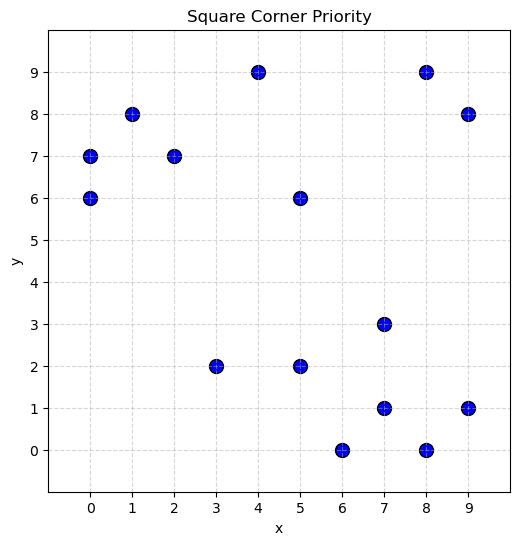

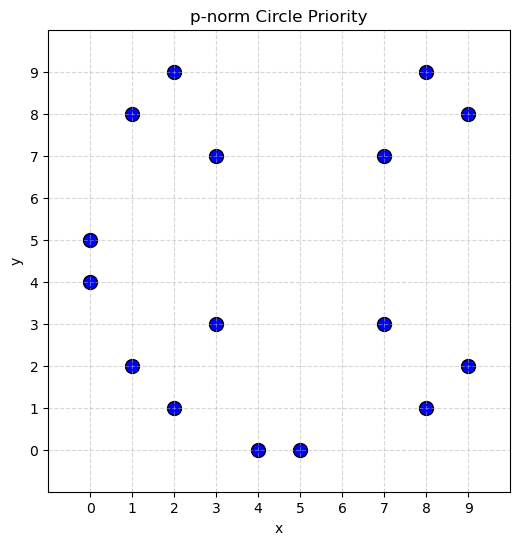

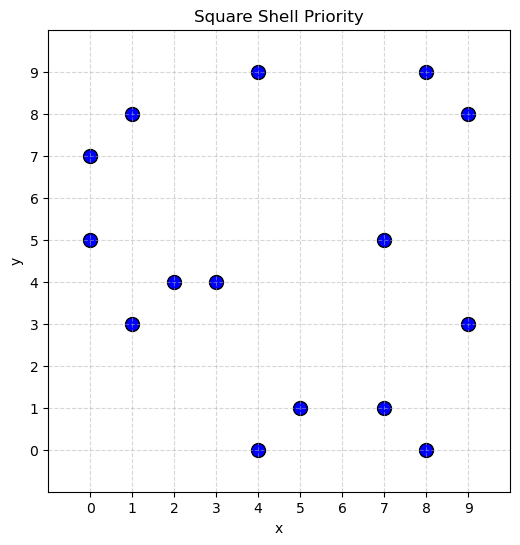

In [30]:
n_points = 10


plot_no_three_in_line(
    greedy(n_points, square_corner_priority(n_points)),
    n_points,
    title="Square Corner Priority"
)
plot_no_three_in_line(
    greedy(n_points, pnorm_circle_priority(n_points)),
    n_points,
    title="p-norm Circle Priority"
)
plot_no_three_in_line(
    greedy(n_points, square_shell_priority(n_points)),
    n_points,
    title="Square Shell Priority"
)
